1- API Key Loading

In [2]:
import os
from dotenv import load_dotenv

# The "../" tells Python to look one folder up (in the WEEK 1 root)
load_dotenv("../.env")

# Retrieve the key
api_key = os.getenv("OPENAI_API_KEY")

if api_key:
    print("✅ API Key successfully loaded!")
else:
    print("❌ API Key not found. Check your .env file location.")

✅ API Key successfully loaded!


2. Imports, Data Loading, and Initial Setup

In [9]:
from datasets import load_dataset
import pandas as pd
from pathlib import Path
from PIL import Image
import base64

# Load the data
dataset = load_dataset("ashraq/fashion-product-images-small", split="train[:100]")
products_df = pd.DataFrame(dataset)

# Add a dummy 'price' column if it doesn't exist
if 'price' not in products_df.columns:
    products_df['price'] = 29.99 # Assign a default price, adjust as needed

#save the images to a local folder    

images_dir = Path("product_images")
images_dir.mkdir(exist_ok=True)
print("✓ Data loaded and folder created.")

# Save each image to the local folder
for index, row in products_df.iterrows():
    image = row['image']
    image.save(images_dir / f"{row['id']}.jpg")

    # Save the PIL image object as a physical file
    if isinstance(row['image'], Image.Image):
            image_path = images_dir / f"{row['id']}.jpg"
            row['image'].save(image_path)           

print(f"✓ Saved images to {images_dir}")

✓ Data loaded and folder created.
✓ Saved images to product_images


Step 3: Encoding Images for API

In [17]:
def encode_image(image_path):
    """Convert a physical image file to a base64 string."""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

Step 4: Creating the Product Listing Prompt

In [4]:
def create_product_listing_prompt(product_name, price, category, additional_info=None):
    """
    Create a prompt for generating product listings.
    
    Parameters:
    - product_name: Name of the product
    - price: Price of the product
    - category: Product category
    - additional_info: Optional additional information
    
    Returns:
    - Formatted prompt string
    """
    prompt = f"""You are an expert e-commerce copywriter. Analyze the product image and create a compelling product listing.

Product Information:
- Name: {product_name}
- Price: ${price:.2f}
- Category: {category}
{f'- Additional Info: {additional_info}' if additional_info else ''}

Please create a professional product listing that includes:

1. **Product Title** (catchy, SEO-friendly, 60 characters max)
2. **Product Description** (detailed, 150-200 words)
   - Highlight key features and benefits
   - Use persuasive language
   - Include relevant details visible in the image
3. **Key Features** (bullet points, 5-7 items)
4. **SEO Keywords** (comma-separated, 10-15 relevant keywords)

Format your response as JSON with the following structure:
{{
    "title": "Product title here",
    "description": "Full description here",
    "features": ["Feature 1", "Feature 2", ...],
    "keywords": "keyword1, keyword2, ..."
}}

Be specific about what you see in the image. Mention colors, materials, design elements, and any distinctive features."""
    
    return prompt

# Test prompt creation
test_prompt = create_product_listing_prompt(
    product_name="Wireless Bluetooth Headphones",
    price=79.99,
    category="Electronics",
    additional_info="Noise cancelling, 30-hour battery"
)

print("\n" + "="*50)
print("PROMPT TEMPLATE")
print("="*50)
print(test_prompt[:1000] + "...")  # Show first 500 characters



PROMPT TEMPLATE
You are an expert e-commerce copywriter. Analyze the product image and create a compelling product listing.

Product Information:
- Name: Wireless Bluetooth Headphones
- Price: $79.99
- Category: Electronics
- Additional Info: Noise cancelling, 30-hour battery

Please create a professional product listing that includes:

1. **Product Title** (catchy, SEO-friendly, 60 characters max)
2. **Product Description** (detailed, 150-200 words)
   - Highlight key features and benefits
   - Use persuasive language
   - Include relevant details visible in the image
3. **Key Features** (bullet points, 5-7 items)
4. **SEO Keywords** (comma-separated, 10-15 relevant keywords)

Format your response as JSON with the following structure:
{
    "title": "Product title here",
    "description": "Full description here",
    "features": ["Feature 1", "Feature 2", ...],
    "keywords": "keyword1, keyword2, ..."
}

Be specific about what you see in the image. Mention colors, materials, design

Step 5: Calling the ChatGPT API with Vision

In [5]:
import os
import json
import base64
from openai import OpenAI
from dotenv import load_dotenv

load_dotenv("../.env")
api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)

# 1. Function to encode the image to base64 (Required for Step 3/5)
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# 2. Select a product to test (First product in your DataFrame)
product_data = products_df.iloc[0]
image_path = images_dir / f"{product_data['id']}.jpg"

# 3. Generate the prompt using your Step 4 function
prompt_text = create_product_listing_prompt(
    product_name=product_data.get('productDisplayName', 'Product'),
    price=product_data['price'],
    category=product_data.get('masterCategory', 'General')
)

# 4. Prepare the API Call
print(f"Calling OpenAI for product: {product_data.get('productDisplayName')}...")

try:
    # We use 'gpt-4o' or 'gpt-4-turbo' because they have Vision capabilities
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt_text},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{encode_image(image_path)}"
                        },
                    },
                ],
            }
        ],
        response_format={ "type": "json_object" } # Forces the AI to give us valid JSON
    )

    # 5. Parse the Response
    result_text = response.choices[0].message.content
    listing_json = json.loads(result_text)

    print("\n✓ API Response Received!")
    print(json.dumps(listing_json, indent=4))

except Exception as e:
    print(f"⚠ Error calling the API: {e}")

Calling OpenAI for product: Turtle Check Men Navy Blue Shirt...

✓ API Response Received!
{
    "title": "Stylish Men's Navy Blue Checkered Shirt - Turtle Check",
    "description": "Refresh your wardrobe with the Turtle Check Men Navy Blue Shirt, a stylish and versatile piece perfect for any occasion. Crafted with a sharp navy blue and white checkered pattern, this shirt exudes a modern, sophisticated look that is both eye-catching and elegant. Made from premium quality breathable cotton, it ensures all-day comfort whether you're in the office or out on the town. The full sleeves can be neatly rolled up for a more casual flair, while the classic collar adds a touch of formality. Designed for the fashion-forward man, this shirt pairs seamlessly with jeans for a relaxed outfit or with chinos for a smart casual style. Elevate your fashion game effortlessly with this must-have wardrobe staple.",
    "features": [
        "Premium quality cotton fabric",
        "Navy blue and white checke

Step 6: Processing Multiple Products

In [6]:
import requests  
import time      
import json
import os

# 1. Ensure the key is loaded
api_key = os.getenv("OPENAI_API_KEY")

all_product_listings = []
API_ENDPOINT = "https://api.openai.com/v1/chat/completions"

for index, product_data in products_df.head(5).iterrows():
    print(f"\n--- Processing Product ID: {product_data['id']} ---")
    try:
        # Preparation
        image_path = images_dir / f"{product_data['id']}.jpg"
        if not image_path.exists():
            continue

        base64_image = encode_image(image_path)
        product_prompt = create_product_listing_prompt(
            product_name=product_data['productDisplayName'],
            price=product_data['price'],
            category=product_data['masterCategory']
        )

        # 2. Build the request
        payload = {
            "model": "gpt-4o-mini",
            "messages": [
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": product_prompt},
                        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}}
                    ]
                }
            ],
            "response_format": { "type": "json_object" } # Added this for easier parsing
        }

        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {api_key}"
        }

        # 3. Execution
        response = requests.post(API_ENDPOINT, headers=headers, json=payload)
        response.raise_for_status() 

        # 4. Parsing
        result_text = response.json()['choices'][0]['message']['content']
        product_listing = json.loads(result_text)
        
        all_product_listings.append({
            "product_id": product_data['id'],
            "listing": product_listing
        })
        print(f"✓ Success for ID: {product_data['id']}")

    except Exception as e:
        print(f"⚠ Failed for ID {product_data['id']}: {e}")

    time.sleep(1) 

print(f"\nDone! Processed {len(all_product_listings)} products.")



--- Processing Product ID: 15970 ---
✓ Success for ID: 15970

--- Processing Product ID: 39386 ---
✓ Success for ID: 39386

--- Processing Product ID: 59263 ---
✓ Success for ID: 59263

--- Processing Product ID: 21379 ---
✓ Success for ID: 21379

--- Processing Product ID: 53759 ---
✓ Success for ID: 53759

Done! Processed 5 products.


Listings for 3 products


############################################################
✨ PRODUCT 1: Turtle Check Men Navy Blue Shirt ✨
############################################################


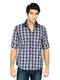


📌 TITLE: Turtle Check Men Navy Blue Shirt

📝 DESCRIPTION:
Elevate your wardrobe with the sophisticated and versatile Turtle Check Men Navy Blue Shirt, a must-have for any modern gentleman. Crafted with care, this shirt features a classic check pattern in timeless navy blue, perfectly blending style with casual elegance. Whether you're heading to a business meeting or a weekend get-together, this shirt ensures you look your best in every setting.

Constructed from high-quality, breathable fabric, the Turtle Check Men Navy Blue Shirt offers unparalleled comfort throughout the day. The tailored fit accentuates your silhouette, providing a polished yet relaxed look. With attention to detail in every stitch, this shirt is designed to offer durability and long-lasting wear without compromising on style.

Pair this versatile shirt with your favorite jeans for a casual vibe or dress it up with trousers for a more formal appearance. Its adaptability makes it an essential piece in your apparel 

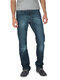


📌 TITLE: Peter England Men's Party Blue Jeans

📝 DESCRIPTION:
Elevate your style quotient with Peter England Men's Party Blue Jeans, perfect for any social gathering or night out. Expertly crafted with a modern slim fit, these jeans offer both comfort and sophistication. The deep indigo blue hue exudes a timeless appeal, making them a versatile addition to your wardrobe.

These jeans are designed with premium-quality denim that ensures durability and long-lasting wear. The subtle whiskering and fading along the thighs and knees add a touch of contemporary flair. Pair them with a casual shirt or a chic blazer to create a standout look that’s suitable for any occasion.

With Peter England's dedication to excellence, you can trust the craftsmanship and attention to detail in every stitch. Whether you're heading to a party, a casual day out, or a semi-formal event, these jeans provide the perfect balance of style and comfort without breaking the bank.

✅ FEATURES:
  • Modern slim fit desi

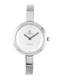


📌 TITLE: Elegant Titan Women Silver Watch

📝 DESCRIPTION:
Embrace sophistication and timeless style with the Titan Women Silver Watch, an elegant accessory that complements any wardrobe. Meticulously crafted with precision and a keen eye for detail, this stunning timepiece blends classic design with modern flair. Its sleek silver tone and minimalist aesthetic make it an exquisite choice for both everyday wear and special occasions. Whether you're dressing up for a formal event or adding a touch of class to your casual ensemble, this watch is your go-to accessory.

The Titan Women Silver Watch features a durable stainless steel strap that comfortably hugs your wrist, ensuring both style and comfort throughout the day. Its carefully engineered quartz movement guarantees accurate timekeeping, so you'll never miss a beat. The watch face is shielded by scratch-resistant glass, maintaining its pristine appearance despite the rigors of daily life. With water resistance added to its repertoir

In [24]:
from IPython.display import display

# 1. Container for results
generated_listings = []

# 2. Loop through the first 3 products
for index, product_data in products_df.head(3).iterrows():
    
    prompt_text = create_product_listing_prompt(
        product_name=product_data.get('productDisplayName', 'Product'),
        price=product_data['price'],
        category=product_data.get('masterCategory', 'General')
    )

    try:
        image_path = images_dir / f"{product_data['id']}.jpg"
        base64_image = encode_image(image_path)

        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": prompt_text},
                        {
                            "type": "image_url",
                            "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                        },
                    ],
                }
            ],
            response_format={ "type": "json_object" }
        )

        # Parse the JSON
        listing_json = json.loads(response.choices[0].message.content)
        generated_listings.append(listing_json)

        # --- DISPLAY IMAGE AND CONTENT ---
        print(f"\n{'#'*60}")
        print(f"✨ PRODUCT {index + 1}: {product_data.get('productDisplayName')} ✨")
        print(f"{'#'*60}")

        # This line actually shows the image in your notebook cell
        # We use .thumbnail to keep it a reasonable size
        img_preview = product_data['image'].copy()
        img_preview.thumbnail((200, 200))
        display(img_preview)

        print(f"\n📌 TITLE: {listing_json.get('title')}")
        print(f"\n📝 DESCRIPTION:\n{listing_json.get('description')}")
        print(f"\n✅ FEATURES:")
        for feature in listing_json.get('features', []):
            print(f"  • {feature}")
        
        print(f"\n🔍 KEYWORDS: {listing_json.get('keywords')}")
        print(f"\n{'='*60}\n")

    except Exception as e:
        print(f"⚠ Error on Product {index + 1}: {e}")

Cost tracking

############################################################
RUNNING LISTING GENERATION WITH COST TRACKING
############################################################


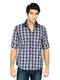

💰 Cost for this item: $0.0035
🎟️ Tokens: 326 in / 270 out
------------------------------


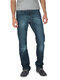

💰 Cost for this item: $0.0038
🎟️ Tokens: 326 in / 296 out
------------------------------


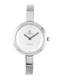

💰 Cost for this item: $0.0039
🎟️ Tokens: 324 in / 311 out
------------------------------

TOTAL BATCH COST: $0.0112
AVG COST PER PRODUCT: $0.0037


In [25]:
# Pricing as of current GPT-4o rates (approx $2.50 per 1M input, $10.00 per 1M output)
# Note: Image tokens vary, but a standard low-res detail image is ~85-170 tokens.
INPUT_COST_PER_1K = 0.0025  
OUTPUT_COST_PER_1K = 0.010

total_input_tokens = 0
total_output_tokens = 0

print(f"{'#'*60}\nRUNNING LISTING GENERATION WITH COST TRACKING\n{'#'*60}")

for index, product_data in products_df.head(3).iterrows():
    try:
        # (Prepare prompt and image as before...)
        image_path = images_dir / f"{product_data['id']}.jpg"
        base64_image = encode_image(image_path)
        prompt_text = create_product_listing_prompt(
            product_name=product_data.get('productDisplayName', 'Product'),
            price=product_data['price'],
            category=product_data.get('masterCategory', 'General')
        )

        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[{"role": "user", "content": [
                {"type": "text", "text": prompt_text},
                {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}}
            ]}],
            response_format={ "type": "json_object" }
        )

        # --- EXTRACT TOKEN USAGE ---
        usage = response.usage
        in_tokens = usage.prompt_tokens
        out_tokens = usage.completion_tokens
        
        total_input_tokens += in_tokens
        total_output_tokens += out_tokens

        # Calculate cost for this specific request
        current_cost = (in_tokens / 1000 * INPUT_COST_PER_1K) + (out_tokens / 1000 * OUTPUT_COST_PER_1K)

        # Display results
        img_preview = product_data['image'].copy()
        img_preview.thumbnail((150, 150))
        display(img_preview)
        
        print(f"💰 Cost for this item: ${current_cost:.4f}")
        print(f"🎟️ Tokens: {in_tokens} in / {out_tokens} out")
        print("-" * 30)

    except Exception as e:
        print(f"⚠ Error: {e}")

# --- FINAL SUMMARY ---
total_cost = (total_input_tokens / 1000 * INPUT_COST_PER_1K) + (total_output_tokens / 1000 * OUTPUT_COST_PER_1K)
print(f"\n{'='*60}")
print(f"TOTAL BATCH COST: ${total_cost:.4f}")
print(f"AVG COST PER PRODUCT: ${(total_cost/3):.4f}")
print(f"{'='*60}")